<a href="https://colab.research.google.com/github/LuellaS/testRepo/blob/main/Praca_domowa_15_12_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''Trains a simple deep NN on the MNIST dataset.

Gets to 99.6% test accuracy after 40 epochs
(there is *a lot* of margin for parameter tuning).
2 seconds per epoch on a K520 GPU.
'''

from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.optimizers import RMSprop, Adam, Adadelta

from keras.utils.vis_utils import plot_model
from IPython.display import Image 
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import EarlyStopping

# install optuna
! pip install optuna

import optuna


batch_size = 128
num_classes = 10
epochs = 50

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train0), (x_test, y_test0) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)



x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train0, num_classes)
y_test = keras.utils.to_categorical(y_test0, num_classes)



     |████████████████████████████████| 266kB 13.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163kB 37.2MB/s 
     |████████████████████████████████| 81kB 11.6MB/s 
     |████████████████████████████████| 81kB 11.5MB/s 
     |████████████████████████████████| 133kB 54.2MB/s 
     |████████████████████████████████| 112kB 44.2MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
  Created wheel for optuna: filename=optuna-2.3.0-cp36-none-any.whl size=359761 sha256=d65f8ad2c3bcab0642eb4cefec3e42bb79187c3283d6e9d31afa7a3dc30c158c
  Stored in directory: /root/.cache/pip/wheels/fa/91/19/64b0ec6b964f89c0695a9dc6db6f851d0b54c5381a5c9cadfb
Successfully built optuna
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13702 sha256=f0c940e5d1868794fc509e5d5f6d5043f61b428c3e3b5721ae1ba3148e398d97
  Stored in directory: /root/.cache/pip/

In [2]:
N_TRAIN_EXAMPLES = 1000 #3000
N_TEST_EXAMPLES = 10000
x_train = x_train[:N_TRAIN_EXAMPLES]
x_test = x_test[:N_TEST_EXAMPLES]
y_train = y_train[:N_TRAIN_EXAMPLES]
y_test = y_test[:N_TEST_EXAMPLES]

In [6]:
def c_model():
  # Our old fully connected (dense) network
  #model = Sequential()
  #model.add(Dense(512, activation='relu', input_shape=(784,)))
  #model.add(Dropout(0.2))
  #model.add(Dense(512, activation='relu'))
  #model.add(Dropout(0.2))
  #model.add(Dense(512, activation='relu'))
  #model.add(Dropout(0.2))
  #model.add(Dense(num_classes, activation='softmax'))
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))

  return model

In [7]:
def objective(trial):
  
  rotation_range=trial.suggest_uniform('rotation_range', .00,30)
  zoom_range=trial.suggest_uniform('zoom_range', .00,0.30)
  shift_range=trial.suggest_uniform('shift_range', .00,0.20)
  
  datagen = ImageDataGenerator( 
    rotation_range=rotation_range,
    width_shift_range=shift_range,
    height_shift_range=shift_range,
    zoom_range=zoom_range
    )

  model = c_model()

  from keras.callbacks import EarlyStopping

  model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
  
  e_s=EarlyStopping(monitor='val_accuracy', patience=12, verbose=1)

  history = model.fit(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=0,
                    validation_data=(x_test, y_test), 
                    callbacks=[e_s])

  score = model.evaluate(x_test, y_test,verbose=0)

  return score[1]

In [8]:
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(), sampler=optuna.samplers.TPESampler() )
study.optimize(objective, n_trials=30, timeout=1200)

[I 2020-12-20 20:47:27,060] A new study created in memory with name: no-name-7fbcd020-1ad6-4b75-bfbe-26d28e827cb0
[I 2020-12-20 20:48:08,455] Trial 0 finished with value: 0.968999981880188 and parameters: {'rotation_range': 4.8087297538993425, 'zoom_range': 0.12125206427049057, 'shift_range': 0.146067499251626}. Best is trial 0 with value: 0.968999981880188.
[I 2020-12-20 20:48:37,284] Trial 1 finished with value: 0.9668999910354614 and parameters: {'rotation_range': 27.36851947934714, 'zoom_range': 0.19731808841160237, 'shift_range': 0.1456382122161324}. Best is trial 0 with value: 0.968999981880188.
[I 2020-12-20 20:49:05,610] Trial 2 finished with value: 0.9610999822616577 and parameters: {'rotation_range': 1.2682963832184213, 'zoom_range': 0.09853721148377458, 'shift_range': 0.013772938918969847}. Best is trial 0 with value: 0.968999981880188.
[I 2020-12-20 20:49:34,026] Trial 3 finished with value: 0.9779000282287598 and parameters: {'rotation_range': 21.635380113767358, 'zoom_ran

In [9]:
print("Number trials: {}".format(len(study.trials)))
print("Best trial:")
trial=study.best_trial
print("Value: {}".format(trial.value))
print("Params")
for key, value in trial.params.items():
  print("  {}:{}  ".format(key, value))

Number trials: 30
Best trial:
Value: 0.9793999791145325
Params
  rotation_range:21.724563047778496  
  zoom_range:0.2929540172976975  
  shift_range:0.0459402768839594  


In [10]:
rotation_range=trial.params.get('rotation_range')
zoom_range=trial.params.get('zoom_range')
shift_range=trial.params.get('shift_range')

  
datagen = ImageDataGenerator( 
    rotation_range=rotation_range,
    width_shift_range=shift_range,
    height_shift_range=shift_range,
    zoom_range=zoom_range
    )

model = model()

from keras.callbacks import EarlyStopping

model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

e_s=EarlyStopping(monitor='val_accuracy',patience=12,verbose=1)

history = model.fit(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[e_s]) 


Epoch 1/50
8/8 [==============================] - 1s 102ms/step - loss: 2.2987 - accuracy: 0.1119 - val_loss: 2.1785 - val_accuracy: 0.3903
Epoch 2/50
8/8 [==============================] - 1s 77ms/step - loss: 2.1122 - accuracy: 0.2772 - val_loss: 1.3314 - val_accuracy: 0.6847
Epoch 3/50
8/8 [==============================] - 1s 76ms/step - loss: 1.7306 - accuracy: 0.4044 - val_loss: 0.9594 - val_accuracy: 0.7782
Epoch 4/50
8/8 [==============================] - 1s 76ms/step - loss: 1.3660 - accuracy: 0.5384 - val_loss: 0.6181 - val_accuracy: 0.8138
Epoch 5/50
8/8 [==============================] - 1s 76ms/step - loss: 1.2070 - accuracy: 0.6021 - val_loss: 0.4918 - val_accuracy: 0.8666
Epoch 6/50
8/8 [==============================] - 1s 75ms/step - loss: 0.9197 - accuracy: 0.6906 - val_loss: 0.3216 - val_accuracy: 0.9064
Epoch 7/50
8/8 [==============================] - 1s 75ms/step - loss: 0.8784 - accuracy: 0.7211 - val_loss: 0.3245 - val_accuracy: 0.9133
Epoch 8/50
8/8 [==========

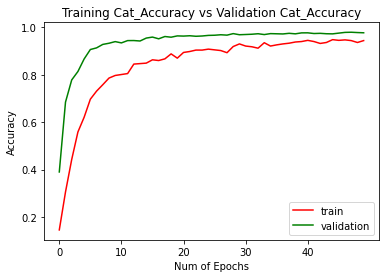

In [11]:
# Plots for training and testing process: loss and accuracy

n_epochs = len(history.history['loss'])

plt.figure(0)
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'g')
plt.xticks(np.arange(0, n_epochs, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Cat_Accuracy vs Validation Cat_Accuracy")
plt.legend(['train','validation'])
 

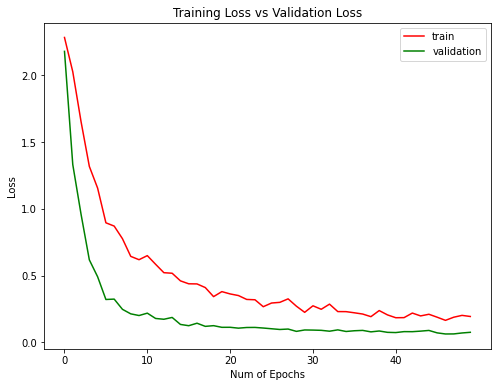

In [12]:
plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, n_epochs, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
plt.show()


(1000, 28, 28)


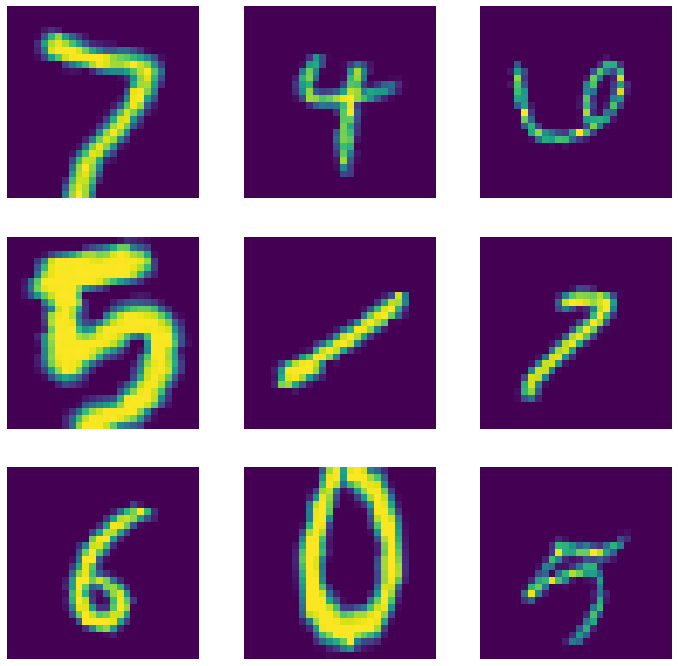

In [13]:
print(x_train.reshape((len(x_train),img_rows, img_cols)).shape)
# see example augmentation images
fig = plt.figure(figsize=(12, 12))
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
         plt.subplot(330 + 1 + i)
         plt.imshow(X_batch[i].reshape((img_rows, img_cols)))
         plt.axis('off')
    plt.show()
    break

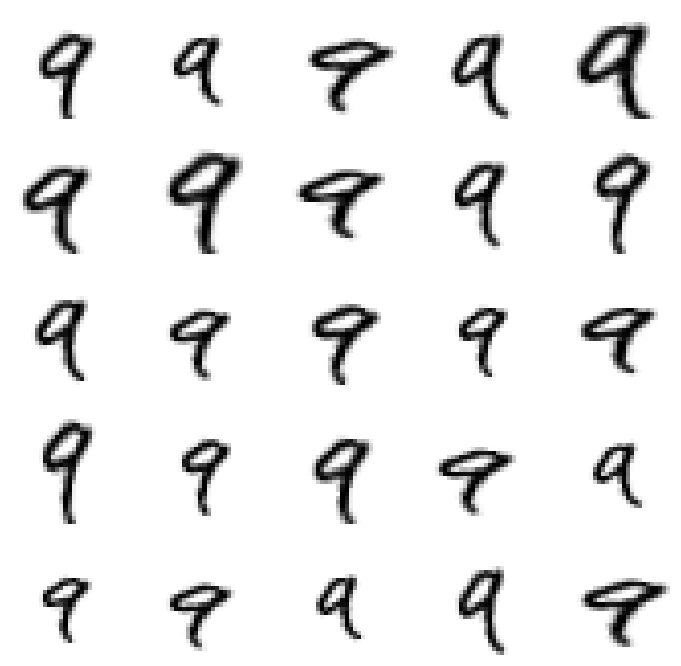

In [14]:
# see example augmentation images
fig = plt.figure(figsize=(12, 12))

for i in range(0, 25):
    for X_batch, y_batch in datagen.flow(x_train[4:6], y_train[4:6], batch_size=1, shuffle=False):
         plt.subplot(5,5,i+1)
         plt.imshow(X_batch[0].reshape((img_rows, img_cols)), cmap=plt.cm.binary, interpolation='nearest')
         plt.axis('off')
         break

plt.show()

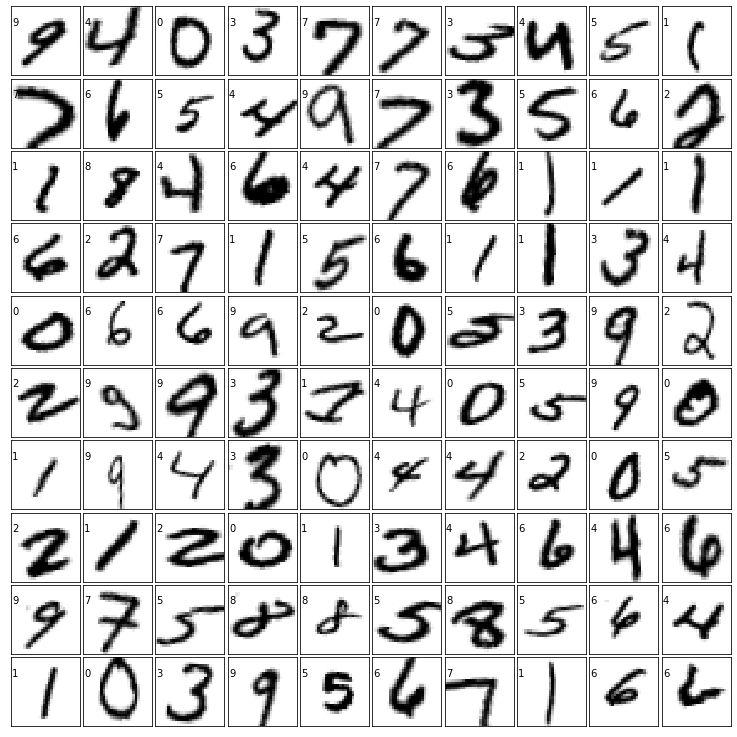

In [15]:
#visualize the digits
fig = plt.figure(figsize=(10, 10)) # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
# generate augmented plot
X_train, Y_train = datagen.flow(x_train,y_train, batch_size=100).next()
for i in range(100):
  ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
  ax.imshow(X_train[i].reshape(img_rows, img_cols), cmap=plt.cm.binary, interpolation='nearest')
  # label the image with the target value
  ax.text(0, 7, str(np.argmax(Y_train[i])))

In [17]:
# evaluate loaded model
scores_train = model.evaluate(x_train, y_train, verbose=0)
scores_test  = model.evaluate(x_test,  y_test,  verbose=0)

print("Accuracy Train: %.2f%% , Test: %.2f%% " % (scores_train[1]*100, scores_test[1]*100 ))

Accuracy Train: 99.10% , Test: 97.69% 


In [18]:
# Confusion matrix result

from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(x_test, verbose=2)

y_pred = np.argmax(Y_pred, axis=1)

y_test2 = np.argmax(y_test, axis=1)



#confusion matrix
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
print(cm)



313/313 - 0s
[[ 976    0    0    1    0    0    1    1    1    0]
 [   0 1115    3    2    0    1    1    7    6    0]
 [   0    0 1025    0    0    0    1    2    3    1]
 [   0    0    2  989    0    8    0    5    4    2]
 [   1    0    1    0  918    0    6    0    0   56]
 [   1    1    0    2    0  876    3    1    4    4]
 [   3    2    0    0    1    3  945    0    4    0]
 [   1    1   17    3    1    0    0  986    3   16]
 [   3    1    5    0    0    0    0    0  944   21]
 [   2    0    0    0    2    1    0    4    5  995]]


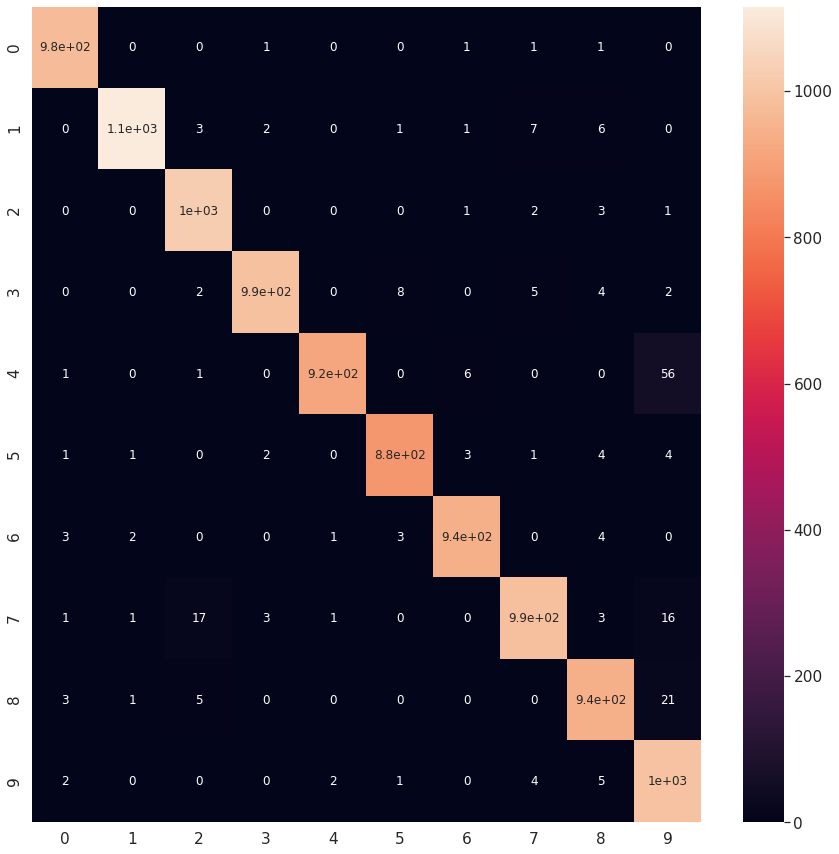

In [19]:
# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd


df_cm = pd.DataFrame(cm, range(10),range(10))
#                     range(num_classes),
#                  range(num_classes))
#plt.figure(figsize = (10,7))
plt.figure(2,figsize = (15,15) )
sn.set(font_scale=1.4) #for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()


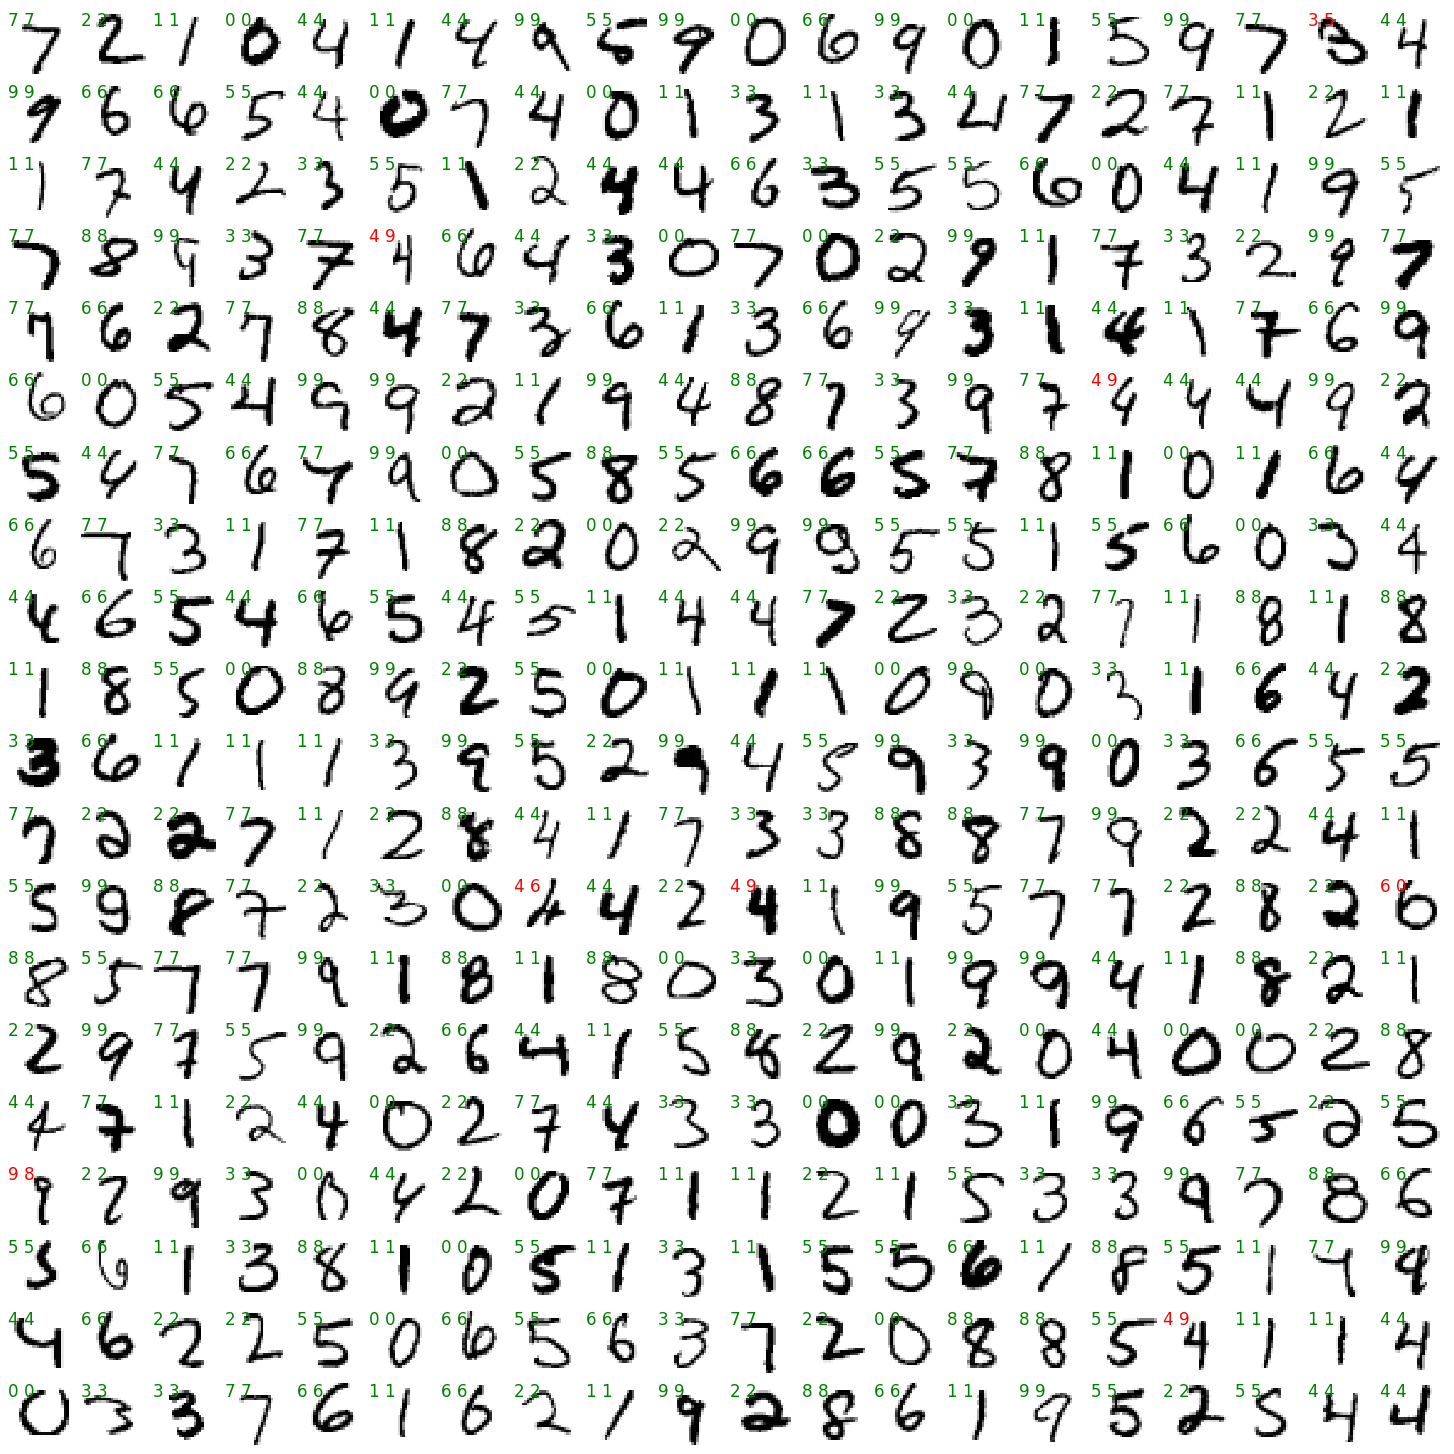

In [20]:
# use the model to predict the labels of the test data
predicted = model.predict(x_test)
expected = y_test0



# Plot the prediction
fig = plt.figure(figsize=(20, 20))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)


# plot the digits: each image is 28x28 pixels
for i in range(400):
    ax = fig.add_subplot(20, 20, i + 1, xticks=[], yticks=[])
    ax.imshow(x_test[i].reshape(img_rows, img_cols), cmap=plt.cm.binary, interpolation='nearest')

    # label the image with the target value
    if np.argmax(predicted[i]) == expected[i]:
        ax.text(0, 7, str(expected[i])+" "+str(np.argmax(predicted[i])), color='green')
    else:
        ax.text(0, 7, str(expected[i])+" "+str(np.argmax(predicted[i])), color='red')

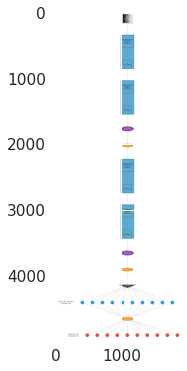

In [21]:
# Creates the graph.png file

! pip3 install keras-visualizer
from keras_visualizer import visualizer  

#create the graph.png image
visualizer(model=model, view=True, format='png', filename='graph')

#show the graph
import matplotlib.image as mpimg
img = mpimg.imread('graph.png')
imgplot = plt.imshow(img,)
plt.show()
